In [1]:
from fastai.text import *

In [2]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/models'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/cc.fr.300.bin'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/giga-fren.tgz'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/giga-fren/data_save.pkl')]

## 加载数据
定义 collate 函数，将训练数据 pad 到同一长度

In [12]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

定义databunch的创建方法

In [3]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [4]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [5]:
# 读取数据
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [6]:
src = (Seq2SeqTextList.from_df(df, path = path, cols='fr')
                       .split_by_rand_pct()
                       .label_from_df(cols='en', label_cls=TextList))

In [7]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

29.0

In [8]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

26.0

In [9]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [10]:
len(src.train) + len(src.valid)

47389

In [13]:
data = load_data(path)

In [14]:
data.show_batch()

text,target
xxbos face aux xxunk offrons - nous de la formation avec solde aux réservistes s’ils ne sont pas tenus de répondre à l’appel lorsque leur pays a besoin d’eux ?,xxbos why are we paying reserves to train when they may not answer the bell when their country needs them ?
"xxbos pourquoi est - ce important d'évaluer les compétences en lecture , en xxunk et en mathématiques à un âge aussi jeune que celui des élèves de xxunk année ?","xxbos why is it important to assess reading , writing and mathematics skills of students at a young age such as in grade 3 ?"
xxbos quand les élections parlementaires de la xxunk régionale de la république tchétchène vont - elle avoir lieu comme cela est prévu dans la constitution de la république tchétchène ?,xxbos when will the parliamentary elections to the regional duma of the chechen republic be held as foreseen under the constitution of the chechen republic ?
xxbos pouvez - vous expliquer pourquoi les quatre pays participants ont décidé de xxunk à ce moment - ci et pourquoi leurs premiers travaux porteront sur les produits financiers ?,"xxbos why did the four countries involved decide to join forces at this time , and why is the initial focus on financial products ?"
"xxbos après le 1er avril 2007 , que fera - t - on des candidats à la formation do nt les noms apparaissent sur la liste d’attente de l’école ?","xxbos what will happen on april 1st , 2007 to those candidates whose names are on the school waiting list ?"


## transform 模型
![](https://github.com/fastai/fastai_docs/raw/4efab562a5f61f0a273eaa3c45d56896d7c8d546/dev_course/dl2/images/Transformer.png)

### 1. 变换训练数据

In [15]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [16]:
data.add_tfm(shift_tfm)

### 2. embedding
为了加入位置信息，我们需要在embedding中加入Position信息

In [17]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        # embedding 大小        
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

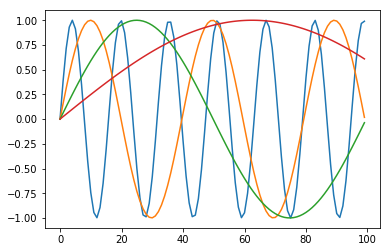

In [18]:
# torch.ger 外积
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [24]:
# 
tst_encoding.freq.shape, res.shape

(torch.Size([10]), torch.Size([100, 20]))

In [25]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        # 这边不是简单的两个embedding相加，而是有个
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

前馈网络

In [26]:
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

## 多头attention

我们的输入：
```
query：单个query
(n_head, 1, d_head)
key: seq_len 个 key
(n_head, seq_len, d_head)
value: 
(n_head, seq_len, d_head)

n_head = 8
d_head = 10
seq_len = 6
q = torch.randn(n_head, 1, d_head)
k = torch.randn(n_head, seq_len, d_head)
# 
q.size(), k.size(), torch.matmul(q, k.permute(0,2,1)).size()
> (torch.Size([8, 1, 10]), torch.Size([8, 6, 10]), torch.Size([8, 1, 6]))

输出是：score = (n_head, 1, seq_len)

下一步将 score 和 val sum_weight：

score: (n_head, 1, seq_len)
val : (n_head, seq_len, d_head)

输出：
(n_head, 1, d_head)

下一步我们假设输入
query：seq_len 个 query
(n_head, seq_len, d_head)
key: seq_len 个 key
(n_head, seq_len, d_head)
value: 
(n_head, seq_len, d_head)
我们最终的输出是：
(n_head, seq_len, d_head)

当单个query 和 key 输出是：score = (n_head, 1, seq_len)
那当有 seq_len 个query，则输出 scores = (n_head, seq_len, seq_len)
然后score再与val相乘：
score: (n_head, seq_len, seq_len)
val : (n_head, seq_len, d_head)
得到：
(n_head, seq_len, d_head)


下面我们考虑mask，即那些我们不关注的位置，我们在计算score的时候，要变为0
对于单个 query，score 是：
(n_head, 1, seq_len)
此时mask应该是:
(1, seq_len)

当我们有 seq_len 个 query，score 是：
(n_head, seq_len, seq_len)
此时的mask应该是：
(1, seq_len)

当我们此时加上batch后，
(batch, n_head, seq_len, seq_len)
此时的mask应该是：
(batch, 1, 1, seq_len)

```

```
下一步我们来看下 mask 的计算，大致有几个mask呢？

q, k, v 
query：seq_q_len 个 query
(n_head, seq_q_len, d_head)
key: seq_len 个 key
(n_head, seq_k_len, d_head)
value: 
(n_head, seq_k_len, d_head)

q 针对 k 来计算score，会产生
(n_head, seq_q_len, seq_k_len) 
那我们的mask应该是：
(1, 1, seq_k_len)，前面两维度自动扩到 (n_head, seq_q_len)

```

In [79]:
batch_size = 2
n_head = 8
d_head = 10
seq_q_len = 6
seq_k_len = 4
q = torch.randn(batch_size, n_head, seq_q_len, d_head)
k = torch.randn(batch_size, n_head, seq_k_len, d_head)
v = torch.randn(batch_size, n_head, seq_k_len, d_head)
score = torch.matmul(q, k.permute(0, 1, 3, 2))
mask = k.ne(1)
q.size(), k.size(), score.size(), torch.matmul(score, v).size()

(torch.Size([2, 8, 6, 10]),
 torch.Size([2, 8, 4, 10]),
 torch.Size([2, 8, 6, 4]),
 torch.Size([2, 8, 6, 10]))

In [87]:
# a = k.unsqueeze(1)
# k.unsqueeze

In [34]:
n_head = 8
d_head = 10
seq_len = 6
q = torch.randn(n_head, 1, d_head)
k = torch.randn(n_head, seq_len, d_head)
v = torch.randn(n_head, seq_len, d_head)
# 
score = torch.matmul(q, k.permute(0,2,1))
q.size(), k.size(), score.size(), torch.matmul(score, v).size()

(torch.Size([8, 1, 10]),
 torch.Size([8, 6, 10]),
 torch.Size([8, 1, 6]),
 torch.Size([8, 1, 10]))

In [36]:
n_head = 8
d_head = 10
seq_len = 6
q = torch.randn(n_head, seq_len, d_head)
k = torch.randn(n_head, seq_len, d_head)
v = torch.randn(n_head, seq_len, d_head)
# 
score = torch.matmul(q, k.permute(0,2,1))
score.size(), torch.matmul(score, v).size()

(torch.Size([8, 6, 6]), torch.Size([8, 6, 10]))

下面是具体的代码

In [37]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # add & norm
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)
        
    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Permute and matmul is a little bit faster but this implementation is more readable
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
        if self.scale: attn_score = attn_score.mul_(1/(self.d_head ** 0.5))
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=2))
        attn_vec = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return attn_vec.contiguous().view(bs, seq_len, -1)

获取mask，对于input，我们mask掉padding，对于output，只关注之前的内容

In [91]:
def get_padding_mask(inp, pad_idx:int=1):
#     return None
    return inp.eq(pad_idx)[:,None,None,:]

In [93]:
inp = torch.Tensor([
    [2,3,4,1],
    [2,2,1,1]
])
mask = get_padding_mask(inp)
# inp (batch_size, seq_len)
print(inp.size(), mask.size())
mask

torch.Size([2, 4]) torch.Size([2, 1, 1, 4])


tensor([[[[0, 0, 0, 1]]],


        [[[0, 0, 1, 1]]]], dtype=torch.uint8)

In [39]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

In [60]:
aa = torch.triu(torch.ones(10,10), diagonal=1).byte()
print(aa.size())
aa

torch.Size([10, 10])


tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [59]:
out_mask = get_output_mask(inp)
print(inp.size(), out_mask.size())
out_mask

torch.Size([2, 4]) torch.Size([1, 1, 4, 4])


tensor([[[[0, 1, 1, 1],
          [0, 0, 1, 1],
          [0, 0, 0, 1],
          [0, 0, 0, 0]]]], dtype=torch.uint8)

## encoder & decoder

In [47]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None): return self.ff(self.mha(x, x, x, mask=mask))

In [48]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None): 
        y = self.mha1(x, x, x, mask_out)
        return self.ff(self.mha2(y, enc, enc, mask=mask_in))

## 定义整个模型

In [50]:
class Transformer(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, n_layers:int=6, n_heads:int=8, d_model:int=256, d_head:int=32, 
                 d_inner:int=1024, inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, bias:bool=True, 
                 scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        super().__init__()
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = get_padding_mask(inp, self.pad_idx)
        mask_out = get_output_mask (out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        for enc_block in self.encoder: enc = enc_block(enc, mask_in)
        for dec_block in self.decoder: out = dec_block(out, enc, mask_in, mask_out)
        return self.out(out)

## 定义metric

In [51]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [52]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

## 定义model

In [53]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [54]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func = CrossEntropyFlat())

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


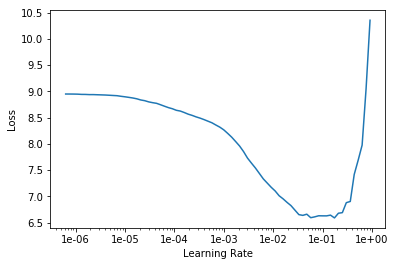

In [68]:
learn.recorder.plot()

此处下降最快的地方应是：1e-3 左右

In [69]:
learn.fit_one_cycle(8, 2*1e-3)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.583944,2.660061,0.596586,0.451043,01:29
1,1.970937,2.031589,0.677933,0.503493,01:29
2,1.725926,1.748796,0.710016,0.534174,01:29
3,1.429026,1.532340,0.734256,0.556406,01:30
4,1.180367,1.384507,0.756237,0.583568,01:30
5,0.934413,1.318126,0.768269,0.598671,01:30
6,0.792054,1.292710,0.775035,0.608056,01:29
7,0.682787,1.299764,0.775580,0.608502,01:30


In [71]:
# learn.model.eval()
for xb, yb in learn.dl(DatasetType.Valid):
#     print(xb)
    break

In [74]:
xb[0].size(), xb[1].size(), yb.size()

(torch.Size([64, 30]), torch.Size([64, 30]), torch.Size([64, 30]))

In [77]:
# xb[0].ne()

In [113]:
from onmt.utils.misc import tile

In [122]:
a = torch.Tensor([[1,2],[3,4]])
b = tile(a, 2, 0)
print(a.shape, b.shape)
print(a)
print(b)

torch.Size([2, 2]) torch.Size([4, 2])
tensor([[1., 2.],
        [3., 4.]])
tensor([[1., 2.],
        [1., 2.],
        [3., 4.],
        [3., 4.]])


In [129]:
torch.tensor([0] + [float("-inf")]*2).repeat(2)

tensor([0., -inf, -inf, 0., -inf, -inf])

In [132]:
# a.view(-1,1)

定义beam_search

In [134]:
for xb, yb in learn.dl(DatasetType.Valid):
    break

In [137]:
src = xb[0]
tgt = xb[1]

In [138]:
src.shape, tgt.shape

(torch.Size([64, 30]), torch.Size([64, 30]))

src和tgt都padding到了同样的长度

In [139]:
# 此处 inp 应该是 q,k,v 中的k和v，让q只关注于非pad的k
mask_in = get_padding_mask(inp, 1)

In [140]:
mask_in.shape

torch.Size([64, 1, 1, 30])

In [142]:
# 对输入进行 encode
enc = learn.model.enc_emb(inp)
for enc_block in learn.model.encoder: enc = enc_block(enc, mask_in)

In [143]:
# batch_size, src_seq_len, encode_dim
enc.shape

torch.Size([64, 30, 256])

decoder现在比较关键，先定义一些辅助变量

In [144]:
bs = enc.shape[0]

In [146]:
beam_size = 2

In [225]:
active_seq = torch.full([bs * beam_size, 1], 1).long().cuda()

In [214]:
# 先定义decoder的输入，我们已经对tgt进行padding后，所以我们第一个输入是下面的，
# 然后 beam_size 为2的话，需要复制下
print(active_seq[:,:1].shape)
beam_inp = active_seq[:,:1]

torch.Size([128, 1])


接着需要定义路径的分数

In [163]:
topk_log_probs = torch.tensor(
            [0.0] + [float("-inf")] * (beam_size - 1)
        ).repeat(bs)
print(topk_log_probs.shape)

torch.Size([128])


In [165]:
out = learn.model.dec_emb(beam_inp)
out.shape

torch.Size([128, 1, 256])

In [164]:
mask_in = tile(mask_in, beam_size)
mask_in.shape

torch.Size([128, 1, 1, 30])

In [166]:
enc = tile(enc, beam_size)
enc.shape

torch.Size([128, 30, 256])

In [168]:
# mask_out = get_output_mask (out, self.pad_idx)
for dec_block in learn.model.decoder: 
    out = dec_block(out, enc, mask_in, None)
out.shape

torch.Size([128, 1, 256])

In [169]:
out = learn.model.out(out)
out.shape

torch.Size([128, 1, 8159])

In [170]:
topk_log_probs.shape

torch.Size([128])

In [175]:
vocab_size = out.shape[-1]
vocab_size

8159

In [181]:
curr_scores = out[:,-1:,:].squeeze(1)
curr_scores.shape

torch.Size([128, 8159])

In [188]:
curr_scores = topk_log_probs.view(-1, 1).cuda() + curr_scores
curr_scores.shape

torch.Size([128, 8159])

下一步，我们要讲 curr_scores reshape 为 (batch, beam_size * vocab_size)

In [189]:
curr_scores = curr_scores.view(bs, beam_size * vocab_size)
curr_scores.shape

torch.Size([64, 16318])

In [195]:
valuse, ids = torch.topk(curr_scores, beam_size)
ids.shape

torch.Size([64, 2])

In [200]:
# 获取到每个batch的起始位置
beam_offset = torch.arange(0, bs * beam_size, beam_size).long()
beam_offset.shape

torch.Size([64])

In [204]:
batch_index = torch.div(ids, vocab_size) # 获取到分别是在各自哪个 batch 中
batch_index = batch_index + beam_offset.unsqueeze(1).cuda() # 获取到batch_index的绝对值
batch_index.shape

torch.Size([64, 2])

In [217]:
# batch_index 就是在beam_inp中的下标
batch_index = batch_index.view(-1)
batch_index.shape

torch.Size([128])

In [210]:
_ = ids.fmod_(vocab_size) # 找出在vocab_size的下标
ids.shape

torch.Size([64, 2])

In [226]:
active_seq = torch.cat([active_seq.index_select(0, batch_index), ids.view(bs*beam_size, 1)],-1)
active_seq.shape

torch.Size([128, 2])

In [229]:
learn.data.train_ds.y.reconstruct(active_seq[1])

Text what

以上就是beam_search的主要思想，当然只是一个半成品，我们还是直接使用OpenNMT的模块来做的

In [242]:
from onmt.translate.beam_search import BeamSearch
from onmt.translate import GNMTGlobalScorer

In [285]:
pad_id = learn.data.train_ds.y.vocab.stoi["xxpad"]
eos_id = learn.data.train_ds.y.vocab.stoi["xxeos"]
bos_id = learn.data.train_ds.y.vocab.stoi["xxbos"]
beam = BeamSearch(
            beam_size,
            n_best=2,
            batch_size=64,
            global_scorer=GNMTGlobalScorer(0.,0.,"none","none"),
            pad=pad_id,
            eos=eos_id,
            bos=bos_id,
            min_length=1,
            ratio=0,
            max_length=30,
            mb_device="cuda:0",
            return_attention=False,
            stepwise_penalty=False,
            block_ngram_repeat=False,
            exclusion_tokens=None,
            memory_lengths=None)

In [278]:
decoder_input = beam.current_predictions.view(-1, 1)
# decoder_input.shape (beam_size*batch_size, 1, 1)
out = learn.model.dec_emb(decoder_input)
out.shape, enc.shape, mask_in.shape

(torch.Size([128, 1, 256]),
 torch.Size([128, 30, 256]),
 torch.Size([128, 1, 1, 30]))

In [279]:
# 获取到log_probs
# mask_out = get_output_mask (out, self.pad_idx)
for dec_block in learn.model.decoder: 
    out = dec_block(out, enc, mask_in, None)
# out.shape
log_probs = F.log_softmax(learn.model.out(out[:,-1:]),-1)
log_probs.shape

torch.Size([128, 1, 8159])

In [280]:
# torch.exp(log_probs[0][0]).sum()
log_probs = log_probs.view(bs*beam_size, -1)
# log_probs: [(batch_size x beam_size), vocab]

In [281]:
with torch.no_grad():
    beam.advance(log_probs, None)

In [282]:
any_beam_is_finished = beam.is_finished.any()

In [284]:
# any_beam_is_finished

tensor([  0,   0,   2,   2,   4,   4,   6,   6,   8,   8,  10,  10,  12,  12,
         14,  14,  16,  16,  18,  18,  20,  20,  22,  22,  24,  24,  26,  26,
         28,  28,  30,  30,  32,  32,  34,  34,  36,  36,  38,  38,  40,  40,
         42,  42,  44,  44,  46,  46,  48,  48,  50,  50,  52,  52,  54,  54,
         56,  56,  58,  58,  60,  60,  62,  62,  64,  64,  66,  66,  68,  68,
         70,  70,  72,  72,  74,  74,  76,  76,  78,  78,  80,  80,  82,  82,
         84,  84,  86,  86,  88,  88,  90,  90,  92,  92,  94,  94,  96,  96,
         98,  98, 100, 100, 102, 102, 104, 104, 106, 106, 108, 108, 110, 110,
        112, 112, 114, 114, 116, 116, 118, 118, 120, 120, 122, 122, 124, 124,
        126, 126], device='cuda:0')

组装下整个过程

In [286]:
pad_id = learn.data.train_ds.y.vocab.stoi["xxpad"]
eos_id = learn.data.train_ds.y.vocab.stoi["xxeos"]
bos_id = learn.data.train_ds.y.vocab.stoi["xxbos"]
beam = BeamSearch(
            beam_size,
            n_best=2,
            batch_size=64,
            global_scorer=GNMTGlobalScorer(0.,0.,"none","none"),
            pad=pad_id,
            eos=eos_id,
            bos=bos_id,
            min_length=1,
            ratio=0,
            max_length=30,
            mb_device="cuda:0",
            return_attention=False,
            stepwise_penalty=False,
            block_ngram_repeat=False,
            exclusion_tokens=None,
            memory_lengths=None)

max_length = 30
with torch.no_grad():
    for step in range(max_length):
#         decoder_input = beam.current_predictions.view(-1, 1)
        decoder_input = beam.alive_seq
        out = learn.model.dec_emb(decoder_input)
        for dec_block in learn.model.decoder: 
            out = dec_block(out, enc, mask_in, None)
        log_probs = F.log_softmax(learn.model.out(out[:,-1:]),-1)
        log_probs = log_probs.view(bs*beam_size, -1)
        beam.advance(log_probs, None)
        any_beam_is_finished = beam.is_finished.any()
        if any_beam_is_finished:
            beam.update_finished()
            if beam.done:
                break

In [290]:
np.shape(beam.scores)

(64, 2)

In [291]:
beam.scores[0]

[tensor(-15.8929, device='cuda:0'), tensor(-16.1143, device='cuda:0')]

In [293]:
learn.data.train_ds.y.reconstruct(beam.predictions[0][0])

Text why is health canada recommended that semen banks banks pay recipients and recipients of testing for testing ?

In [294]:
learn.data.train_ds.y.reconstruct(beam.predictions[0][1])

Text why has health canada recommended that semen banks banks pay recipients and recipients of testing for testing ?

In [295]:
# 整个是
learn.data.train_ds.y.reconstruct(tgt[0])

Text xxbos why has health canada recommended that semen banks recall donors and recipients for testing ?